In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["figure.dpi"] = 120

import seaborn as sns

sns.set_theme(style="darkgrid")

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Laboratory 10

## K-means design and implementation

### Loading the Gaussian clusters dataset

In [206]:
X_clusters = pd.read_csv("../datasets/2D_gauss_clusters.txt", dtype=float).to_numpy()

### Plotting it

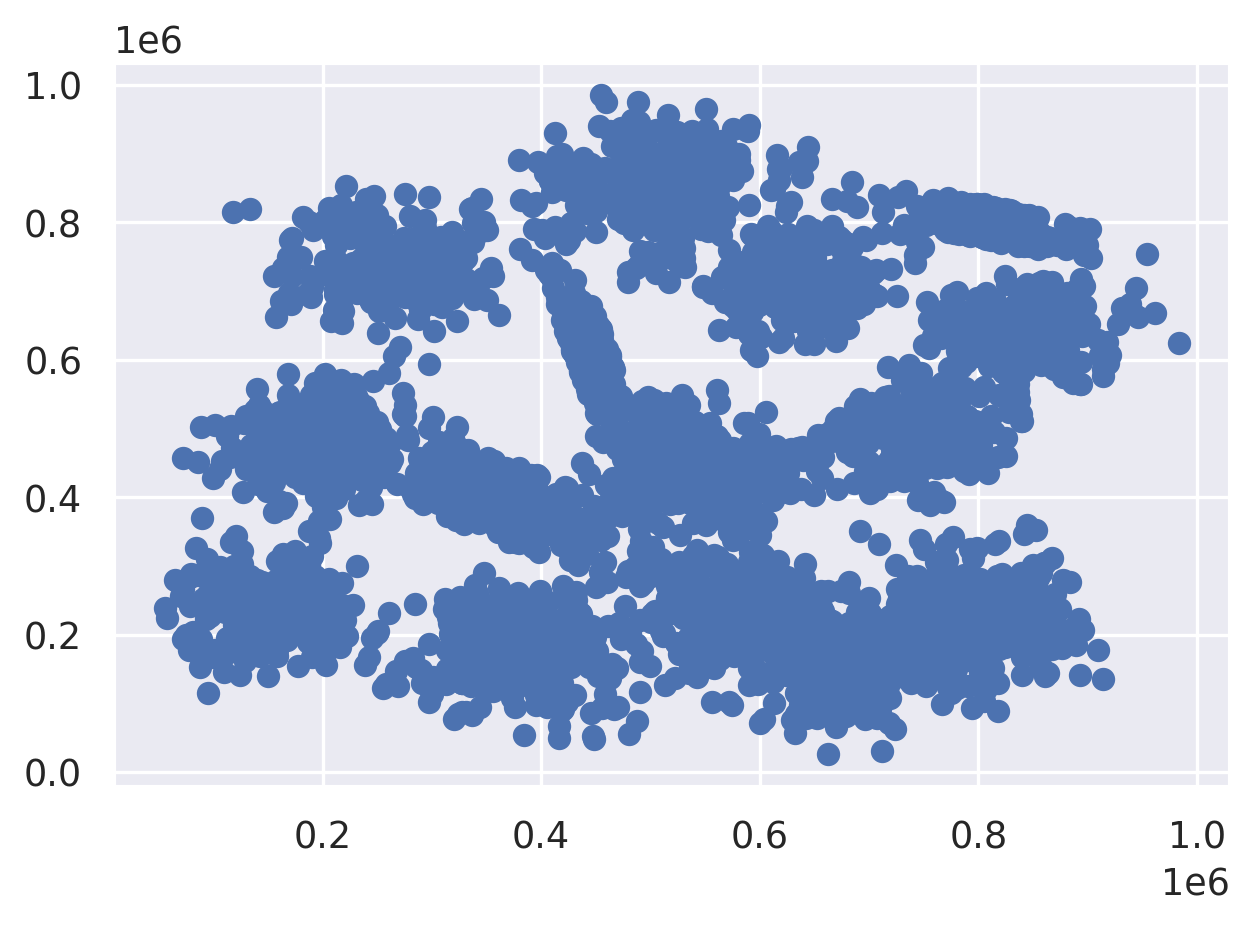

In [207]:
plt.scatter(X_clusters[:, 0], X_clusters[:, 1])

### Implement k-means

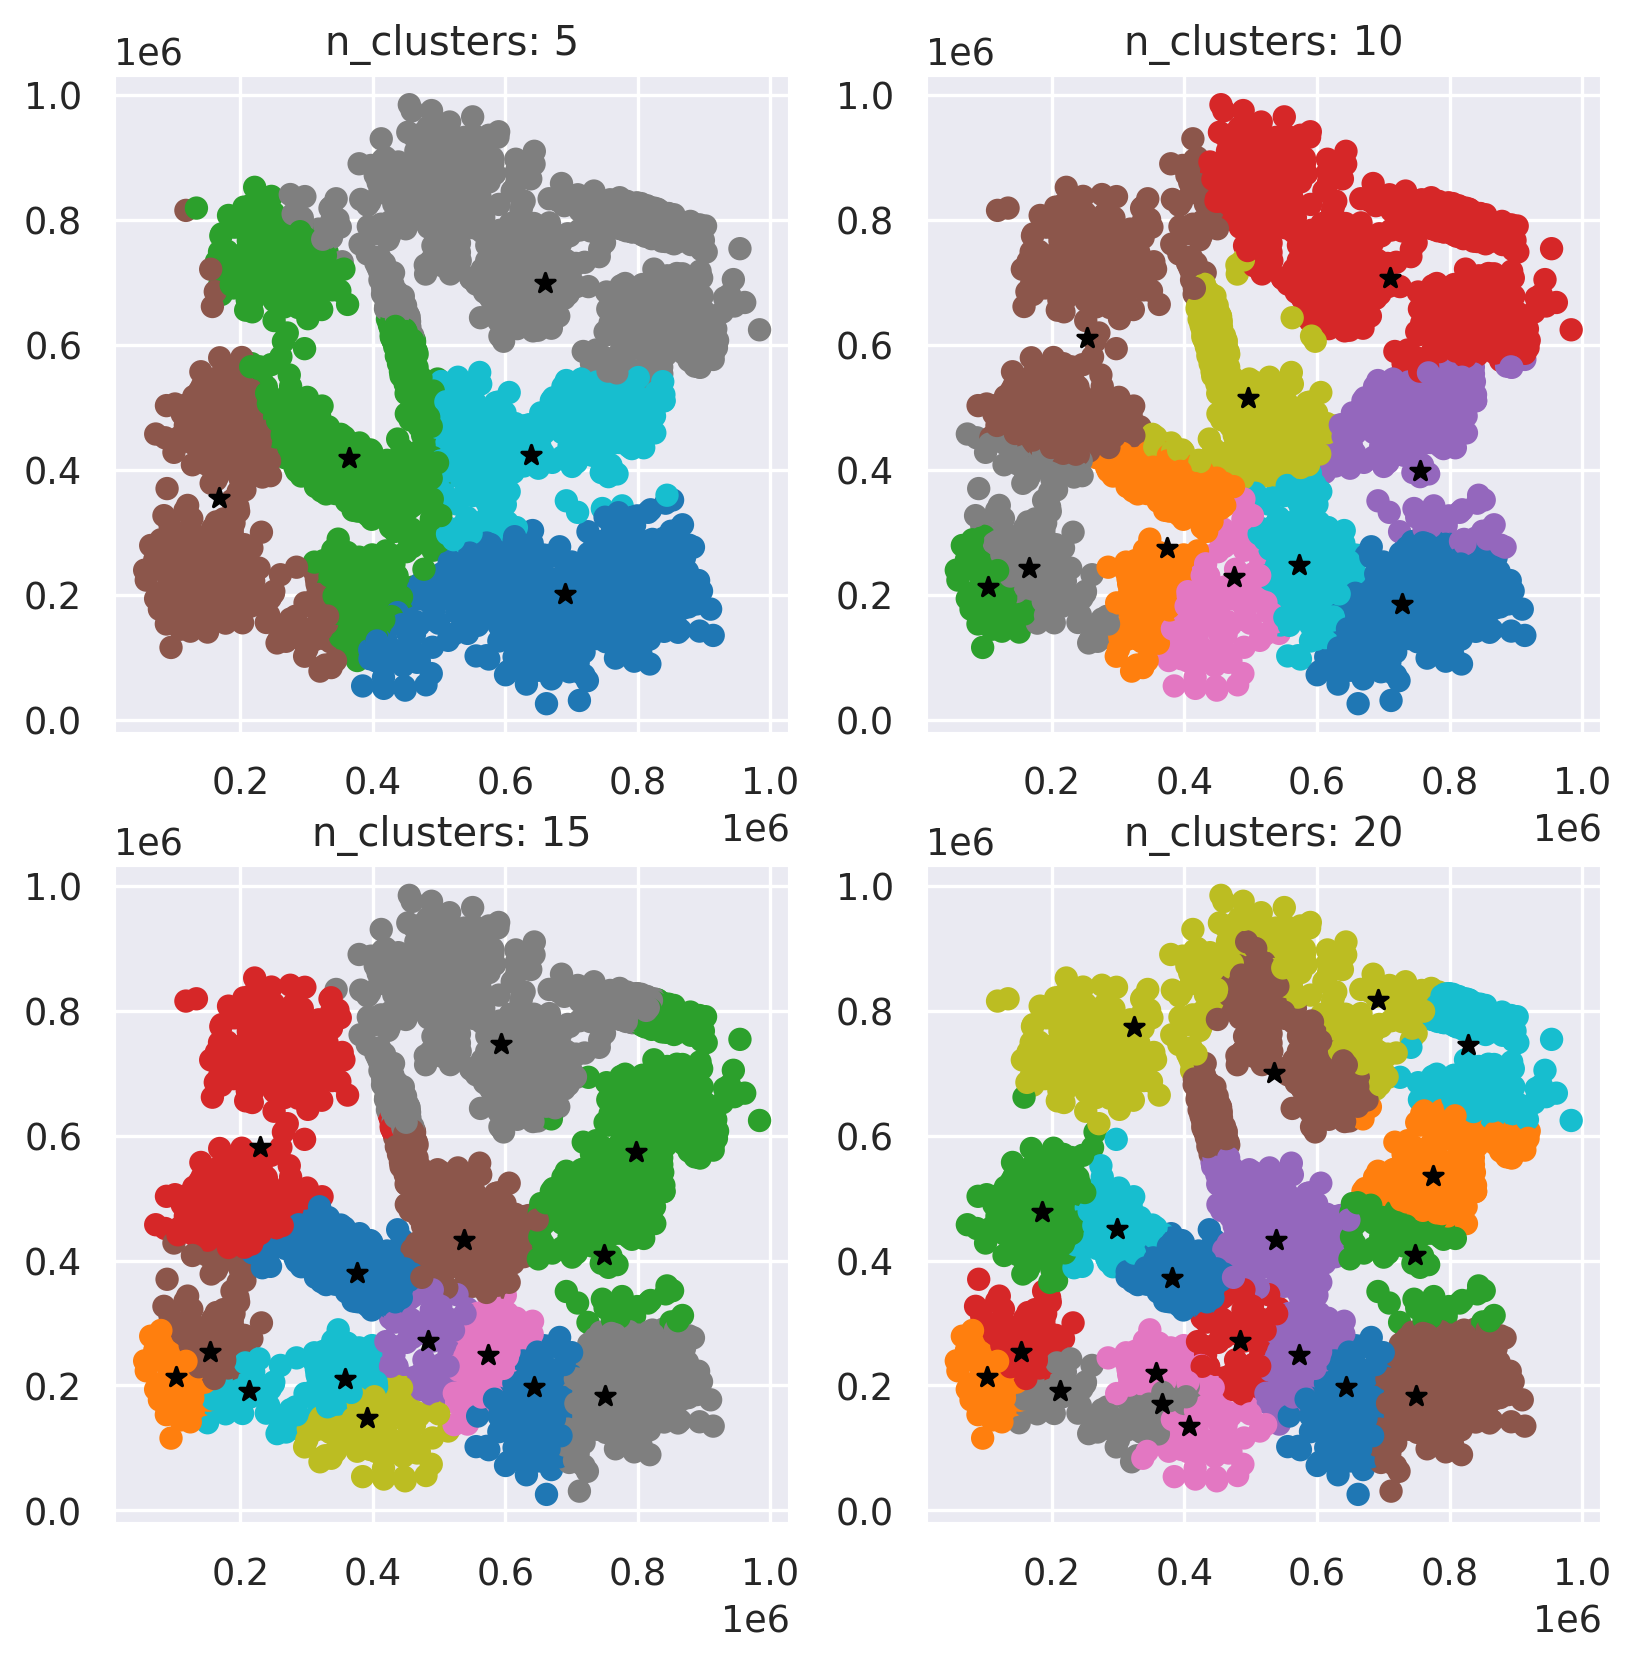

In [282]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100, rng=np.random.default_rng()):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels = None
        self.rng = rng

    def fit_predict(self, X):
        n, _ = X.shape

        # Select n_clusters points as initial centroids
        self.centroids = X[self.rng.integers(low=0, high=n, size=self.n_clusters)]

        # Initially all points belong to the same cluster, the cluster 0
        old_clustering = np.zeros(shape=(n,))
        new_clustering = np.zeros(shape=(n,))

        for _ in range(self.max_iter):
            # For each point, assign it to the closest centroid
            for i in range(n):
                new_clustering[i] = np.argmin(
                    np.linalg.norm(self.centroids - X[i, :], axis=1)
                )

            # after computing the new clusering, stop if they did not change
            if np.allclose(new_clustering, old_clustering):
                break

            # Recompute the centroids
            self.centroids = [
                np.mean(X[new_clustering == cluster, :], axis=0)
                for cluster in range(self.n_clusters)
            ]

            old_clustering = new_clustering

        return old_clustering.astype(int)


_, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, n_clusters in zip(np.ravel(axes), [5, 10, 15, 20]):
    clustering = KMeans(n_clusters=n_clusters, rng=np.random.default_rng(42))
    y_clusters = clustering.fit_predict(X_clusters)

    ax.scatter(X_clusters[:, 0], X_clusters[:, 1], c=y_clusters, cmap="tab10")
    ax.scatter(
        [c[0] for c in clustering.centroids],
        [c[1] for c in clustering.centroids],
        marker="*",
        color="black",
    )
    ax.set_title(f"n_clusters: {n_clusters}")

### kmeans on chameleon data

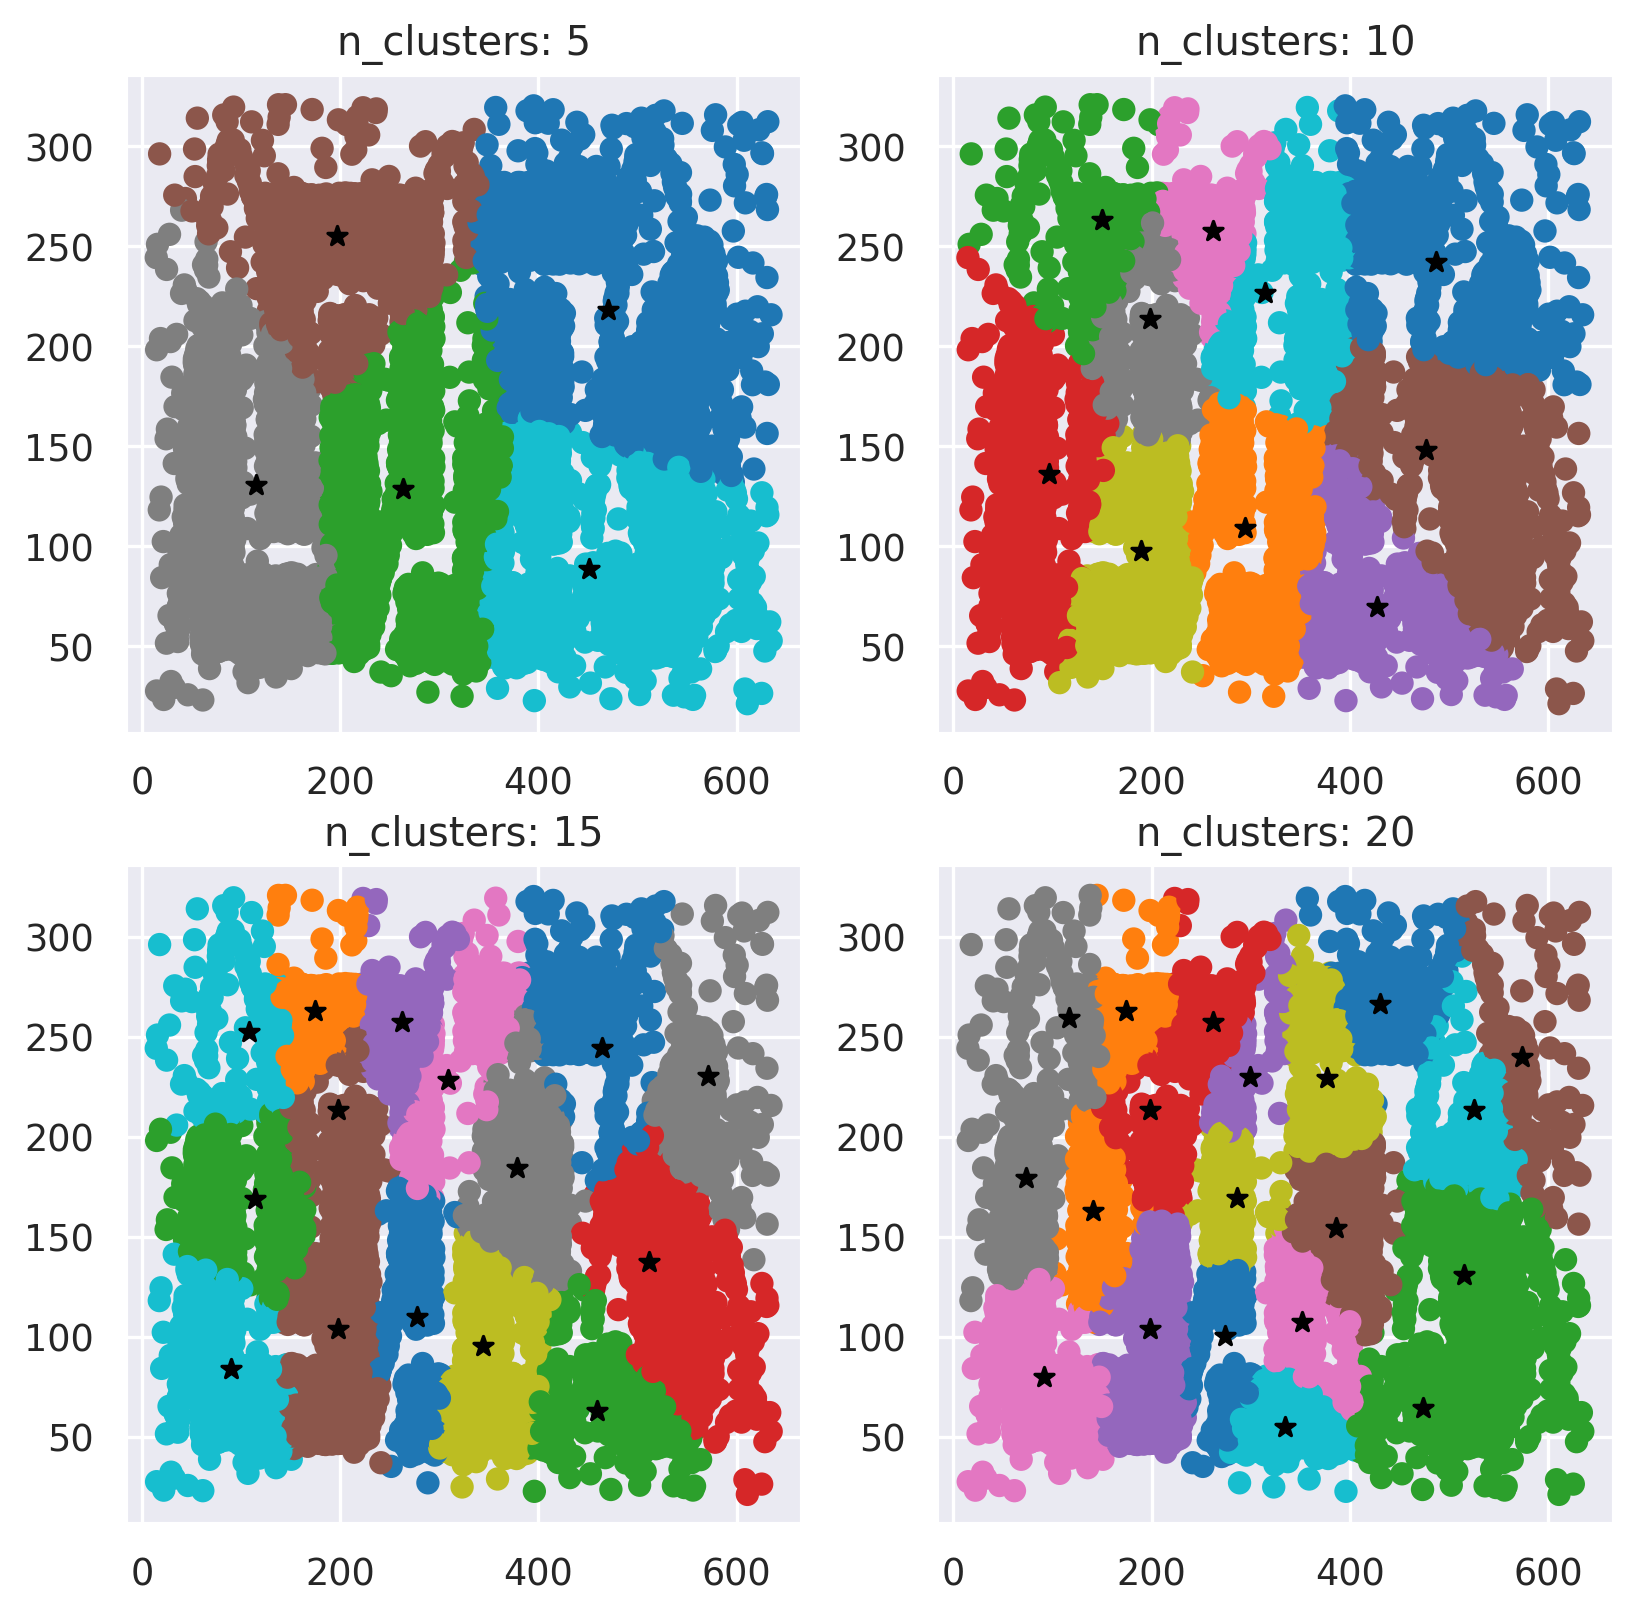

In [283]:
X_chameleon = pd.read_csv("../datasets/chameleon_clusters.txt").to_numpy()

_, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, n_clusters in zip(np.ravel(axes), [5, 10, 15, 20]):
    clustering = KMeans(n_clusters=n_clusters, rng=np.random.default_rng(42))
    y_chameleon = clustering.fit_predict(X_chameleon)

    ax.scatter(X_chameleon[:, 0], X_chameleon[:, 1], c=y_chameleon, cmap="tab10")
    ax.scatter(
        [c[0] for c in clustering.centroids],
        [c[1] for c in clustering.centroids],
        marker="*",
        color="black",
    )
    ax.set_title(f"n_clusters: {n_clusters}")

## Evaluating clustering performance

In [300]:
def silhouette_samples(X, labels):
    i = 1

    # a(i)
    def a(i):
        Ci = X[labels == labels[i], :]
        # no i!=j since d(i,j) = 0
        return (1 / (len(Ci) - 1)) * np.sum(np.linalg.norm(Ci - X[i, :], axis=1))

    def b(i):
        bs = []
        for k in range(0, np.max(labels)):
            if k == labels[i]:
                continue
            Ck = X[labels == k, :]
            bs.append((1 / len(Ck)) * np.sum(np.linalg.norm(Ck - X[i, :], axis=1)))

        return min(bs)

    def s(i):
        return (b(i) - a(i)) / max(a(i), b(i))

    return [s(i) for i in range(X.shape[0])]


def silhouette_score(X, labels):
    return np.mean(silhouette_samples(X, labels))

(array([  12.,   19.,   47.,   90.,  154.,  191.,  226.,  210.,  238.,
         311.,  377.,  494.,  661.,  740.,  901.,  956., 1061.,  921.,
         222.,  169.]),
 array([-0.4468163 , -0.38936469, -0.33191308, -0.27446147, -0.21700986,
        -0.15955825, -0.10210664, -0.04465503,  0.01279658,  0.07024819,
         0.1276998 ,  0.18515141,  0.24260302,  0.30005463,  0.35750624,
         0.41495785,  0.47240946,  0.52986107,  0.58731268,  0.6447643 ,
         0.70221591]),
 <BarContainer object of 20 artists>)

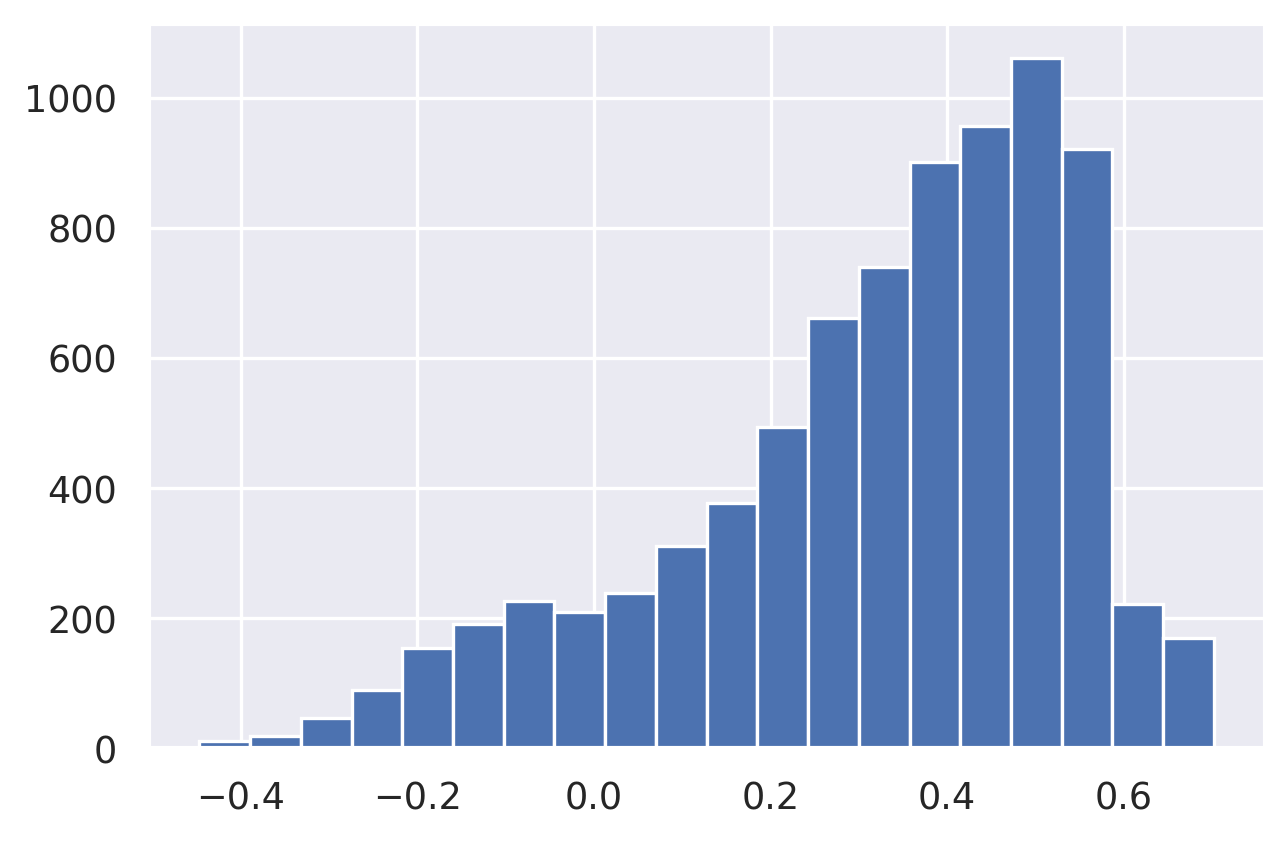

In [301]:
clustering = KMeans(n_clusters=10, rng=np.random.default_rng(42))
y_chameleon = clustering.fit_predict(X_chameleon)
ss_chameleon_10 = silhouette_samples(X_chameleon, y_chameleon)
plt.hist(ss_chameleon_10, bins=20)

(array([ 30.,  36.,  28.,  22., 170., 123.,  87.,  91., 117., 120., 155.,
        241., 281., 360., 650., 620., 781., 456., 315., 317.]),
 array([-0.69622625, -0.62237394, -0.54852163, -0.47466932, -0.40081701,
        -0.3269647 , -0.25311239, -0.17926008, -0.10540777, -0.03155546,
         0.04229685,  0.11614915,  0.19000146,  0.26385377,  0.33770608,
         0.41155839,  0.4854107 ,  0.55926301,  0.63311532,  0.70696763,
         0.78081994]),
 <BarContainer object of 20 artists>)

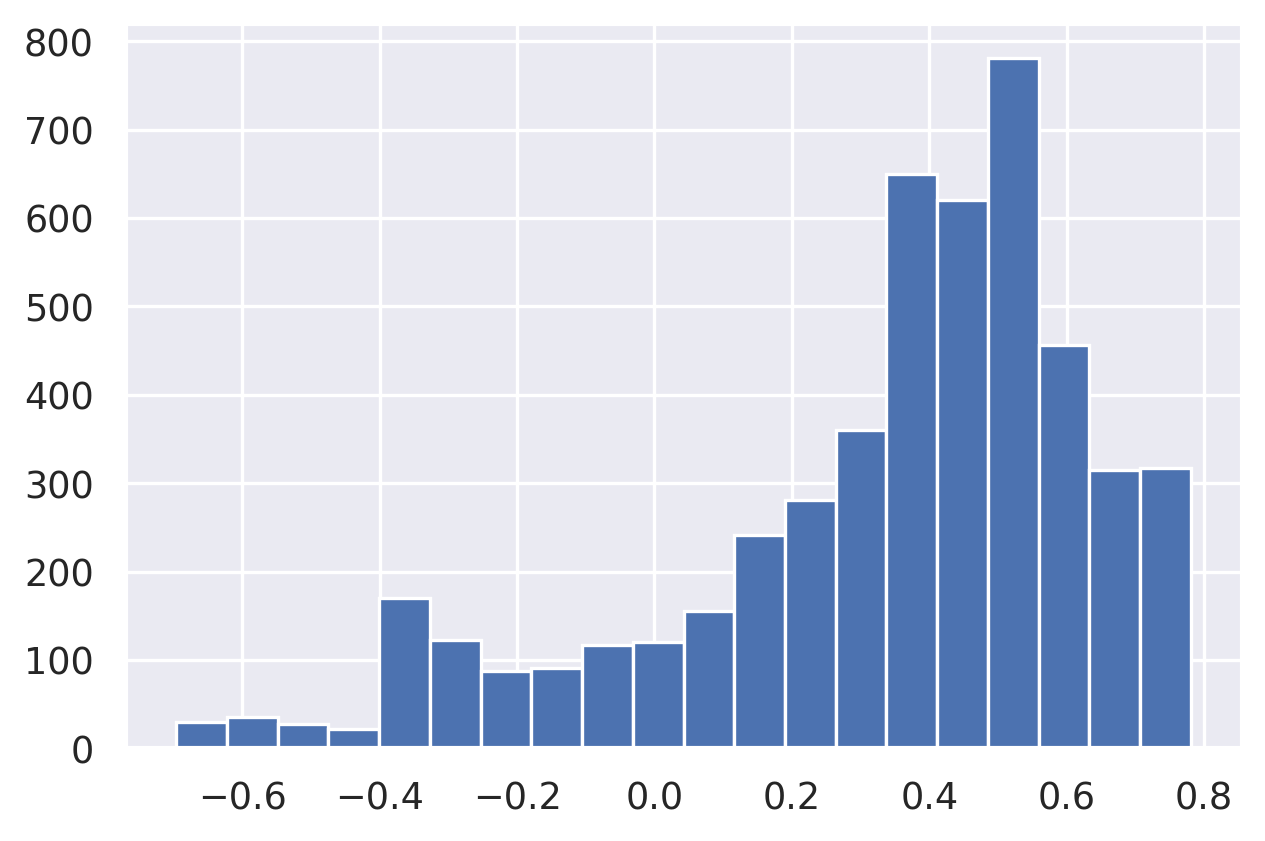

In [303]:
clustering = KMeans(n_clusters=15, rng=np.random.default_rng(42))
y_clusters = clustering.fit_predict(X_clusters)
ss_clusters_15 = silhouette_samples(X_clusters, y_clusters)
plt.hist(ss_clusters_15, bins=20)

### Finding the best K using the silhouette score

In [318]:
silhouette_scores = []
for n_clusters in [5, 7, 10, 12, 15, 18, 20]:
    clustering = KMeans(n_clusters=n_clusters, rng=np.random.default_rng(42))
    y_clusters = clustering.fit_predict(X_clusters)
    silhouette_scores.append(silhouette_score(X_clusters, y_clusters))

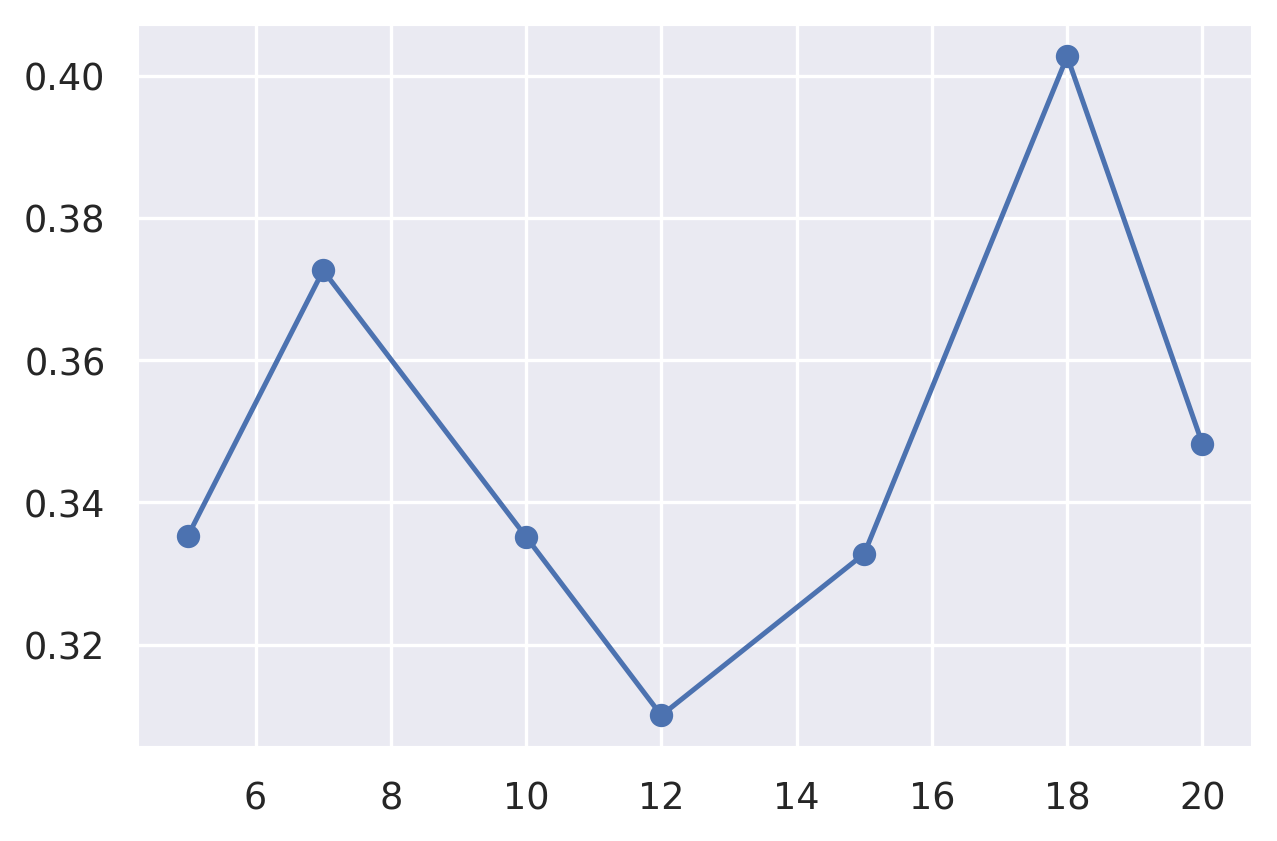

In [319]:
plt.scatter([5, 7, 10, 12, 15, 18, 20], silhouette_scores)
plt.plot([5, 7, 10, 12, 15, 18, 20], silhouette_scores)